# Categorical Data - Statistical Analysis

This notebook uses Scikit-Learn to handle missing data, analyze, and visualize a dataset.

## Importing Libraries

Importing required libraries:
- `pandas`: For data handling.
- `matplotlib.pyplot` and `seaborn`: For plotting.
- `SimpleImputer`: For filling missing values.

In [1]:
import os                                                 # to set current working directory 
import math                                               # basic calculations like square root
from sklearn.model_selection import train_test_split      # train and test split
from sklearn import svm                                   # support vector machine methods
from sklearn import tree                                  # tree program from scikit learn (package for machine learning)
from sklearn.metrics import mean_squared_error, r2_score  # specific measures to check our models
from sklearn.impute import SimpleImputer
import pandas as pd                                       # DataFrames and plotting
import pandas.plotting as pd_plot
import numpy as np                                        # arrays and matrix math
import matplotlib.pyplot as plt                           # plotting
from intake import cat                                    # data catalogue

#### Declare functions

Let's define a couple of functions to streamline plotting correlation matrices and visualization of a machine learning regression model responce over the 2 predictor features. 

In [2]:
def plot_corr(dataframe,size=10):                         # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
def visualize_model(model,xfeature,yfeature,response,title,):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 0.02
    x_min, x_max = min(xfeature) - 1, max(xfeature) + 1
    y_min, y_max = min(yfeature) - 1, max(yfeature) + 1
    resp_min = round(min(response)); resp_max = round(max(response));
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    z_min = round(min(response)); z_max = round(max(response))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max)

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    return(plt)


#### Read the data table

In [3]:
my_data = pd.read_csv("Categorical_HackathonData2024.csv")

## Statistical Analysis

Calculate basic statistics (mean, standard deviation, etc.) for the numeric data.

Let's visualize the first several rows of our data stored in a DataFrame so we can make sure we successfully loaded the data file.

In [4]:
my_data.head()                                            # preview the first 5 rows of the dataframe

,Well ID,Avg Pump Difference,Area,Fluid System,Development Strategy,DELAYED,BOUND_CODE,CODEV_POSITION,CODEV_FORMATION_POSITION
0,1,-0.93,Acadia,Campbell,Coke,1,11100000,Edge,Edge
1,2,-8.45,Acadia,Campbell,Coke,1,11100000,Edge,Edge
2,3,8.70,Arches,Campbell,Orange Crush,0,101111,Middle,Edge
3,5,19.93,Badlands,Campbell,Mountain Dew,1,10001101,Edge,Edge
4,6,-4.34,Big Bend,Campbell,Coke,1,11110000,Edge,Edge


Let's remove the well index and check the summary summary statistics.

In [5]:
nan_percentage = my_data.isna().mean() * 100               # Calculate the percentage of NaN values for each column

# Remove "Well ID" if present
if 'Well ID' in my_data.columns:
    my_data.drop('Well ID', axis=1, inplace=True)
    
stats_description = my_data.describe().transpose()         # calculate summary statistics for the data

stats_description['NaN%'] = nan_percentage   # Add the NaN percentage as a new column

# Display the DataFrame with styling
styled_description = stats_description.style.format("{:.2f}")
styled_description

,count,mean,std,min,25%,50%,75%,max,NaN%
Avg Pump Difference,333.00,22.46,24.33,-12.69,3.86,17.37,34.33,117.26,0.00
DELAYED,333.00,0.71,0.45,0.00,0.00,1.00,1.00,1.00,0.00
BOUND_CODE,333.00,9894515.36,2820923.89,1110.00,10001001.00,11011001.00,11111000.00,11111111.00,0.00


### 

In [15]:
# Calculate the percentage of NaN values for each column
nan_percentage = my_data.isna().mean() * 100

# For categorical data, calculate the frequency of each category
categorical_columns = my_data.select_dtypes(include=['object', 'category']).columns
categorical_summary = {}

# Indent size: change this value to adjust the indentation
indent_size = 6

# Iterate over categorical columns and calculate the overall count, NaN% and frequency data
for col in categorical_columns:
    count = my_data[col].notna().sum()  # Count of non-NaN entries
    nan_pct = nan_percentage[col]       # NaN percentage
    freq_series = my_data[col].value_counts().reset_index()  # Frequency counts for non-NaN values
    freq_series.columns = ['Value', 'Frequency']
    # Apply consistent indentation to the frequency data
    freq_series['Value'] = freq_series['Value'].apply(lambda x: f"{' ':<{indent_size}}{x}")
    categorical_summary[col] = {
        'count': count,
        'NaN%': nan_pct,
        'frequency': freq_series
    }

# Display the summary for each categorical column
for col, summary in categorical_summary.items():
    print(f"\nSummary for {col}:")
    print(f"Count: {summary['count']}")
    print(f"NaN%: {summary['NaN%']:.2f}%")
    print("Frequency:")
    print(summary['frequency'].to_string(index=False))


Summary for Area:
Count: 333
NaN%: 0.00%
Frequency:
                      Value  Frequency
                Great Basin         33
                 Everglades         25
           Petrified Forest         24
                Canyonlands         21
                 Lake Clark         17
                    Glacier         17
                   Big Bend         16
              Mount Rainier         16
               Kings Canyon         16
                     Acadia         12
                Grand Teton         12
           Carlsbad Caverns         11
                Hot Springs         11
        Guadalupe Mountains         10
      Great Smoky Mountains         10
                     Denali         10
               Grand Canyon          9
                   Badlands          9
             North Cascades          8
                    Sequoia          8
                     Arches          7
                Joshua Tree          6
           Great Sand Dunes          5
           

Some values may be negative that cannot be negative so we can truncate these, we will leave the values as is for the time being.

In [7]:
#num = my_data._get_numeric_data()                         # get the numerical values
#num[num < 0] = 0                                          # truncate negative values to 0.0
#my_data.describe().transpose()                            # calculate summary statistics for the data

Plot NaN data for each data set

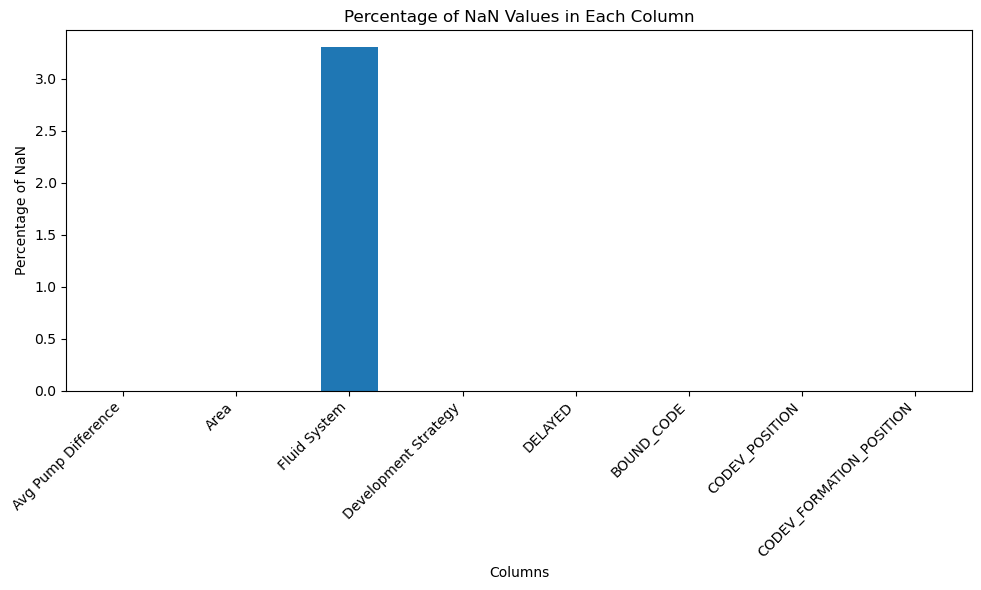

In [8]:
# Plotting the bar chart
plt.figure(figsize=(10, 6))
nan_percentage.plot(kind='bar')
plt.title('Percentage of NaN Values in Each Column')
plt.ylabel('Percentage of NaN')
plt.xlabel('Columns')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

#### Anova (Analysis of Varients)



In [18]:
corr_matrix = np.corrcoef(my_data, rowvar = False)
print(np.around(corr_matrix,2))                           # print the correlation matrix to 2 decimals

TypeError: can only concatenate str (not "float") to str

Note the 1.0 diagonal resulting from the correlation of each variable with themselves.  

Let's use our function declared above to make a graphical correlation matrix visualization.  This may inprove our ability to spot features.  It relies on the built in correlation matrix method with Numpy DataFrames and MatPlotLib for plotting.

In [ ]:
plot_corr(my_data,10)                                      # using our correlation matrix visualization function
plt.show()

This looks good.  There is a mix of correlation magnitudes. Of course, correlation coeffficients are limited to degree of linear correlations.  For more complete information, let's look at the matrix scatter plot from the Pandas package. 

In [ ]:
pd_plot.scatter_matrix(my_data, alpha = 0.1,              # pandas matrix scatter plot
    figsize=(10, 10),color = 'black', hist_kwds={'color':['grey']})
plt.show()

Visualize the distribution of each column of data using a histogram

In [ ]:
def plot_histograms(dataframe, bins=5):
    """
    Plots histograms for each column in the given dataframe.
    
    Args:
    dataframe (pd.DataFrame): The dataframe containing the data.
    bins (int): Number of bins for the histograms. Default is 5.
    """
    for column in dataframe.columns:
        plt.figure()
        dataframe[column].hist(bins=bins)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

# Call the function with your data
plot_histograms(my_data, bins=50)  # Change 'bins' to adjust the number of bins

#### Working with Only Two Predictor Features to Predict One Response Feature - EVERYTHING BELOW HERE IS INCOMPLETE

Let's simplify the problem to 2 features, to predict one response feature, Production rate.  We will also reduce the number of wells from 1,000 to 500.  By working with only 2 predictor features, it is very easy to visualize the segmentation of the feature space (it is only 2D and the model can be interogated exhaustively on a single plot).

We will demonstrate with:

* Porosity and Brittleness

to predict:

* Production

Then you will have a chance to run the workflow again with your own selection for predictor features.

To update the predictor features change the code in the box below:

```python
predictor_features = ['Por','Brittle'] 
```

You can any of these:

1. Por
2. LogPerm
3. AI
4. Brittle
5. TOC
6. VR

Note the feature names are caps sensitive.

In [ ]:
# Select 2 predictor features here:
predictor_features = ['Avg Open Pressure','Avg Close Pressure']           # for the first demonstration run we will use porosity and brittleness

response_feature = 'Avg Pump Difference'

pindex = np.argwhere(my_data.columns.isin(predictor_features)).ravel()
print('Selected predictor features: \n0: ' + predictor_features[0] + ', index = ' + str(pindex[0]) + '.')
print('1: ' + predictor_features[1] + ', index = ' + str(pindex[1]) + '.')
rindex = np.argwhere(my_data.columns.isin([response_feature])).ravel()
print('\nSelected response feature: \n' + response_feature + ', index = ' + str(rindex[0]) + '.')

#my_data_cut = my_data.iloc[0:500,:] 
X = my_data[predictor_features]                # extract the 2 selected response features, 500 samples to a X array
y = my_data[[response_feature]]                # extract selected response 500 samples to a response array

Let's check the summary statistics of Predictor Features 1 and 2 and the Response Feature.

In [ ]:
X.describe().transpose()                   # calculate summary statistics for the data

In [ ]:
y.describe().transpose()                   # calculate summary statistics for the data

Now let's withhold 100 samples as testing data and retain the remaining 400 as training data. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73073)
n_train = len(X_train)
n_test = len(X_test)
print('Number of training ' + str(n_train) + ', number of test ' + str(n_test))

Let's compare the univariate statistics of Predictor Features 1 and 2 and the Response Feature for the training and testing datasets.  
 
 * let's check for bias and extrapolation.

In [ ]:
X_train.describe().transpose()                   # calculate summary statistics for the data

In [ ]:
X_test.describe().transpose()                   # calculate summary statistics for the data

In [ ]:
y_train.describe().transpose()                   # calculate summary statistics for the data

In [ ]:
y_test.describe().transpose()                   # calculate summary statistics for the data

Now let's plot the training and testing dataset distributions to check coverage and extrapolation.

In [ ]:
plt.subplot(231)
plt.hist(X_train[predictor_features[0]], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title(predictor_features[0] + ' Train Dataset'); plt.xlim(fmin[pindex[0]],fmax[pindex[0]])

plt.subplot(232)
plt.hist(X_train[predictor_features[1]], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title(predictor_features[1] + ' Train Dataset'); plt.xlim(fmin[pindex[1]],fmax[pindex[1]])

plt.subplot(233)
plt.hist(y_train[response_feature], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title(response_feature + ' Train Dataset'); plt.xlim(fmin[rindex[0]],fmax[rindex[0]])

plt.subplot(234)
plt.hist(X_test[predictor_features[0]], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title(predictor_features[0] + ' Test Dataset'); plt.xlim(fmin[pindex[0]],fmax[pindex[0]])

plt.subplot(235)
plt.hist(X_test[predictor_features[1]], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title(predictor_features[1] + ' Test Dataset'); plt.xlim(fmin[pindex[1]],fmax[pindex[1]])

plt.subplot(236)
plt.hist(y_test[response_feature], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title(response_feature + ' Test Dataset'); plt.xlim(fmin[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.3)
plt.show()

The distributions are well behaved, we cannot observe obvious gaps nor truncations.  

Let's look at a scatter plot of Predictor Feature 1 vs 2 with points colored by Response Feature.  

* Let's plot the training and testing datasets to check coverage and extrapolation in the features space.

In [ ]:
plt.subplot(121)
im = plt.scatter(X_train[predictor_features[0]],X_train[predictor_features[1]],s=None, c=y_train[response_feature], marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3,  edgecolors="black")
plt.title('Training Data: ' + response_feature + ' vs. ' + predictor_features[1] + ' and ' + predictor_features[0]); plt.xlabel(predictor_features[0]); plt.ylabel(predictor_features[1])
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(fmin[rindex[0]],fmax[rindex[0]], 10));
plt.xlim(fmin[pindex[0]],fmax[pindex[0]]); plt.ylim(fmin[pindex[1]],fmax[pindex[1]])
cbar.set_label(response_feature, rotation=270, labelpad=20)

plt.subplot(122)
im = plt.scatter(X_test[predictor_features[0]],X_test[predictor_features[1]],s=None, c=y_test[response_feature], marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Testing Data: ' + response_feature + ' vs. ' + predictor_features[1] + ' and ' + predictor_features[0]); plt.xlabel(predictor_features[0]); plt.ylabel(predictor_features[1])
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(fmin[rindex[0]],fmax[rindex[0]], 10)); 
plt.xlim(fmin[pindex[0]],fmax[pindex[0]]); plt.ylim(fmin[pindex[1]],fmax[pindex[1]])
cbar.set_label(response_feature, rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

#### Building a Linear Regression Model

Let's build our first machine learning model with scikit learn.  We will start with linear regression.  For this model we will pick one predictor feature and one response feature.  

In [ ]:
# Linear Regression Model with scikit learn
from sklearn import linear_model

# Step 1. Instantiate the Model 
univariate_linear_reg = linear_model.LinearRegression()

# Step 2: Fit the Data on Training Data
univariate_linear_reg.fit(X_train[predictor_features[0]].values.reshape(n_train,1), y_train[response_feature]) # fit model
univariate_linear_model = np.linspace(fmin[pindex[0]],fmax[pindex[0]],10)

# Print the model parameters
response_model = univariate_linear_reg.predict(univariate_linear_model.reshape(10,1)) # predict with the fit model
print('Coefficients: ', str(round(univariate_linear_reg.coef_[0],3)) + ', Intercept: ', str(round(univariate_linear_reg.intercept_,3))) 

# Plot model fit
plt.figure(figsize=(8,6))
plt.scatter(X_train[predictor_features[0]].values, y_train[response_feature],  color='black', s = 20, alpha = 0.3)
plt.plot(univariate_linear_model,response_model, color='red', linewidth=1)
plt.title('Linear Regression Production from ' + predictor_features[0] + ' on Training'); plt.xlabel(predictor_features[0]); plt.ylabel('Production (MCFPD)')
plt.xlim(fmin[pindex[0]],fmax[pindex[0]]); plt.ylim(fmin[rindex[0]],fmax[rindex[0]])


We can now check our model performance against the withheld testing data.

In [ ]:
# Step 3: - Make predictions using the testing dataset
y_pred = univariate_linear_reg.predict(X_test[predictor_features[0]].values.reshape(n_test,1))

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(y_test, y_pred))

# Plot testing diagnostics 
plt.subplot(121)
plt.scatter(X_test[predictor_features[0]].values, y_test[response_feature].values,  color='black', s = 20, alpha = 0.3)
plt.scatter(X_test[predictor_features[0]], y_pred, color='blue', s = 20, alpha = 0.3)
plt.title('Linear Regression Model Testing - ' + response_feature + ' from ' + predictor_features[0]); 
plt.xlabel(predictor_features[0]); plt.ylabel(response_feature)
plt.xlim(fmin[pindex[0]],fmax[pindex[0]]); plt.ylim(fmin[rindex[0]],fmax[rindex[0]])

y_res = y_pred - y_test[response_feature].values

plt.subplot(122)
plt.hist(y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Linear Regression Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0]); 
plt.xlabel(response_feature + ' Estimation Error'); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

Now let's see how our linear regression model performs with just the second predictor feature.

In [ ]:
# Step 1. Instantiate the Model 
univariate_linear_reg2 = linear_model.LinearRegression()

# Step 2: Fit the Data on Training Data
univariate_linear_reg2.fit(X_train[predictor_features[1]].values.reshape(n_train,1), y_train[response_feature]) # fit model
univariate_linear_model2 = np.linspace(fmin[pindex[1]],fmax[pindex[1]],10)

# Print the model parameters
response_model2 = univariate_linear_reg2.predict(univariate_linear_model2.reshape(10,1)) # predict with the fit model
print('Coefficients: ', str(round(univariate_linear_reg.coef_[0],3)) + ', Intercept: ', str(round(univariate_linear_reg.intercept_,3))) 

# Plot model fit
plt.figure(figsize=(8,6))
plt.scatter(X_train[predictor_features[1]].values, y_train[response_feature],  color='black', s = 20, alpha = 0.3)
plt.plot(univariate_linear_model2,response_model2, color='red', linewidth=1)
plt.title('Linear Regression Production from ' + predictor_features[1] + ' on Training'); plt.xlabel(predictor_features[1]); plt.ylabel('Production (MCFPD)')
plt.xlim(fmin[pindex[1]],fmax[pindex[1]]); plt.ylim(fmin[rindex[0]],fmax[rindex[0]])

In [ ]:
# Step 3: - Make predictions using the testing dataset
y_pred2 = univariate_linear_reg2.predict(X_test[predictor_features[1]].values.reshape(n_test,1))

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(y_test, y_pred2))

# Plot testing diagnostics 
plt.subplot(121)
plt.scatter(X_test[predictor_features[1]].values, y_test[response_feature].values,  color='black', s = 20, alpha = 0.3)
plt.scatter(X_test[predictor_features[1]], y_pred2, color='blue', s = 20, alpha = 0.3)
plt.title('Linear Regression Model Testing - ' + response_feature + ' from ' + predictor_features[1]); 
plt.xlabel(predictor_features[1]); plt.ylabel(response_feature)
plt.xlim(fmin[pindex[1]],fmax[pindex[1]]); plt.ylim(fmin[rindex[0]],fmax[rindex[0]])

y_res2 = y_pred2 - y_test[response_feature].values

plt.subplot(122)
plt.hist(y_res2, alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Linear Regression Model Prediction Error - ' + response_feature + ' from ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error'); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

#### Building a Multilinear Regression Model

Let's build our second machine learning model with scikit learn.  We will work with multilinear regression!  We will use both predictor features, porosity and brittleness, and one response feature, production.  

There are no hyperparameters to tune with regular linear regression.

* note: ridge regression and LASSO offer alternatives to linear regression with regularization coefficient, a hyperparameter.

In [ ]:
# Linear Regression Model with scikit learn
from sklearn import linear_model

# Step 1. Instantiate the Model 
multilinear_reg = linear_model.LinearRegression()

# Step 2: Fit the Data on Training Data
multilinear_reg.fit(X_train.values.reshape(n_train,2), y_train[response_feature]) # fit model

# Print the model parameters
print(predictor_features[0] + ' Coef: ' + str(round(multilinear_reg.coef_[0],3)) + ', ' + predictor_features[1] + ' Coef: ', str(round(multilinear_reg.coef_[1],3)) + ', Intercept: ', str(round(multilinear_reg.intercept_,3))) 

# Plot model fit
plt.subplot(121)
plt = visualize_model(multilinear_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Testing Data and Multilinear Regression Model')

# Step 3: - Make predictions using the testing dataset
multilinear_y_pred = multilinear_reg.predict(X_test.values.reshape(n_test,2))

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(y_test, multilinear_y_pred))

# Calculate the error at withheld testing samples
multilinear_y_res = multilinear_y_pred - y_test[response_feature].values

plt.subplot(122)
plt.hist(multilinear_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Linear Regression Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.6, wspace=0.1, hspace=0.2)
plt.show()


Including brittleness only resulted in a slight improvement.  

* due to the nonlinear nature of brittleness

#### Building a Decision Tree Regression Model

Let's build our third machine learning model with scikit learn.  We will work with a decision tree.  We will use both predictor features, porosity and brittleness, and one response feature, production.

The hyperparameters include:

* **min_samples_leaf** - the minimum number of data in each region, reduce to increase complexity
* **max_depth** - maximum number of layers of decisions, increase to increase complexity
* **max_leaf_nodes** - maximum number of regions, increase to increase complexity

In [ ]:
# Decison Tree Model with scikit learn
from sklearn import tree                                     # for accessing tree information

# Step 1. Instantiate the Model 
decision_tree_reg = tree.DecisionTreeRegressor(min_samples_leaf=5, max_depth = 3)

# Step 2: Fit the Data on Training Data
decision_tree_reg.fit(X_train.values.reshape(n_train,2), y_train[response_feature]) # fit model

# Plot model fit
plt.subplot(121)
plt = visualize_model(decision_tree_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Testing Data and Decision Tree Model')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.3, hspace=0.2)

# Step 3: - Make predictions using the testing dataset
tree_y_pred = decision_tree_reg.predict(X_test.values.reshape(n_test,2))

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(y_test, tree_y_pred))

# Calculate the error at withheld testing samples
tree_y_res = tree_y_pred - y_test['Production'].values

plt.subplot(122)
plt.hist(tree_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Decision Tree Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.6, wspace=0.1, hspace=0.2)
plt.show()

#### Building a Support Vector Machine Regression Model

Let's build our fourth machine learning model with scikit learn.  We will work with a support vector machine!  We will use both predictor features, porosity and brittleness, and one response feature, production.  

The hyperparameters include:

* **kernel** - try linear, poly and rbf (radial basis function), for poly increase degree to increase complexity
* **C** - cost (inverse of margin width) - increase to increase complexity

In [ ]:
# Support Vector Regression Model with scikit learn
from sklearn import linear_model

# Step 1. Instantiate the Model 
support_vector_reg = svm.SVR(kernel='poly', C=0.010, gamma='auto', degree=2, epsilon=.01,coef0=1,max_iter=1000)

# Step 2: Fit the Data on Training Data
support_vector_reg.fit(X_train.values.reshape(n_train,2), y_train[response_feature]) # fit model

# Plot model fit
plt.subplot(121)
plt = visualize_model(support_vector_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Testing Data and Support Vector Model')

# Step 3: - Make predictions using the testing dataset
svm_y_pred = support_vector_reg.predict(X_test.values.reshape(n_test,2))

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(y_test, svm_y_pred))

# Calculate the error at withheld testing samples
svm_y_res = svm_y_pred - y_test['Production'].values

plt.subplot(122)
plt.hist(svm_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Support Vector Machine Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.6, wspace=0.1, hspace=0.2)
plt.show()

Let's put all our models together for one visualization of our:

* models with the withheld testing data

* error at withheld testing data samples distribution

In [ ]:
plt.subplot(231)
plt = visualize_model(multilinear_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Training Data and Multilinear Regression Model')

plt.subplot(234)
plt.hist(multilinear_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Linear Regression Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplot(232)
plt = visualize_model(decision_tree_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Training Data and Decision Tree Model')

plt.subplot(235)
plt.hist(tree_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Decision Tree Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplot(233)
plt = visualize_model(support_vector_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Training Data and Support Vector Model')

plt.subplot(236)
plt.hist(svm_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Support Vector Machine Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=2.6, wspace=0.1, hspace=0.2)
plt.show()

I'll end here for brevity, but I invite you to continue. There are many other scikit learn methods to explore and there are further opportunities for model cross validation and hyperparameter tuning.  

* return to the beginning and select a different pair of predictor features and try again

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

In [ ]:
# Replace 'your_data.csv' with the path to your dataset
file_path = 'Cleaned_HackathonData2024.csv'
data = pd.read_csv(file_path)

In [ ]:
# Separating numeric and non-numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])
non_numeric_data = data.select_dtypes(exclude=['float64', 'int64'])

# Imputers for different types of data
numeric_imputer = SimpleImputer(strategy='mean')
non_numeric_imputer = SimpleImputer(strategy='most_frequent')

# Imputation
numeric_data_imputed = pd.DataFrame(numeric_imputer.fit_transform(numeric_data), columns=numeric_data.columns)
non_numeric_data_imputed = pd.DataFrame(non_numeric_imputer.fit_transform(non_numeric_data), columns=non_numeric_data.columns)

# Combine the data back
data_imputed_combined = pd.concat([numeric_data_imputed, non_numeric_data_imputed], axis=1)

In [ ]:
# Basic statistical analysis on the imputed numeric data
statistical_analysis_numeric = numeric_data_imputed.describe()
statistical_analysis_numeric

In [ ]:
# Visualization of the completeness of the dataset before and after imputation
plt.figure(figsize=(12, 6))

# Before imputation
plt.subplot(1, 2, 1)
sns.heatmap(data.isna(), cbar=False)
plt.title('Before Imputation')
plt.xlabel('Columns')
plt.ylabel('Index')

# After imputation
plt.subplot(1, 2, 2)
sns.heatmap(data_imputed_combined.isna(), cbar=False)
plt.title('After Imputation')
plt.xlabel('Columns')
plt.ylabel('Index')

plt.tight_layout()
plt.show()

In [ ]:
# Scikit-Learn Demonstration

Demonstration of scikit learn for machine learning.

In this workflow we demonstrate the plug and play nature of scikit learn machine learning models.  

For an unconventional dataset we demonstrate the following steps:
    
    1. instantiation
    2. fitting
    3. prediction
    4. cross validation
    
We will work with the following regression methods:

* linear regression
* multilinear regression
* decision tree regression
* support vector machine regression

We will demonstrate together a model and then you will pick any 2 predictor features and build your own model.

* try some new hyperparameters and observe the model performance

We will also need some standard packages.

import os                                                 # to set current working directory 
import math                                               # basic calculations like square root
from sklearn.model_selection import train_test_split      # train and test split
from sklearn import svm                                   # support vector machine methods
from sklearn import tree                                  # tree program from scikit learn (package for machine learning)
from sklearn.metrics import mean_squared_error, r2_score  # specific measures to check our models
from sklearn.impute import SimpleImputer
import pandas as pd                                       # DataFrames and plotting
import pandas.plotting as pd_plot
import numpy as np                                        # arrays and matrix math
import matplotlib.pyplot as plt                           # plotting
from intake import cat                                    # data catalogue

#### Declare functions

Let's define a couple of functions to streamline plotting correlation matrices and visualization of a machine learning regression model responce over the 2 predictor features. 

def plot_corr(dataframe,size=10):                         # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
def visualize_model(model,xfeature,yfeature,response,title,):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 0.02
    x_min, x_max = min(xfeature) - 1, max(xfeature) + 1
    y_min, y_max = min(yfeature) - 1, max(yfeature) + 1
    resp_min = round(min(response)); resp_max = round(max(response));
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    z_min = round(min(response)); z_max = round(max(response))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max)

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    return(plt)


#### Read the data table

my_data = pd.read_csv("Numerical_HackathonData2024.csv")

Let's visualize the first several rows of our data stored in a DataFrame so we can make sure we successfully loaded the data file.

my_data.head()                                            # preview the first 5 rows of the dataframe

Let's remove the well index and check the summary summary statistics.

my_data = my_data.iloc[:,1:33]                             # copy all rows and columns 1 through 8, note 0 column is removed
my_data.describe().transpose()                            # calculate summary statistics for the data

It is good that we checked the summary statistics, because we have some negative values for brittleness and total organic carbon. The is physically imposible.  The values must be in error. We know the lowest possible values are 0.0, so we will truncate on 0.0.  We use the *get_numerical_data()* DataFrame member function to get a shallow copy of the data from the DataFrame.  Since it is a shallow copy, any changes we make to the copy are made to the data in the original DataFrame.  This allows us to apply this simple conditional statement to all the data values in the DataFrame all at once.

#num = my_data._get_numeric_data()                         # get the numerical values
#num[num < 0] = 0                                          # truncate negative values to 0.0
#my_data.describe().transpose()                            # calculate summary statistics for the data

Let's assign min and max values for visualization

fmin = [-15,2200,7250,0,250,125,140]
fmax = [125,18500,11000,10,3000,3000,3000]

This dataset has variables from 1,000 unconventional wells including well average porosity, log transform of permeability (to linearize the relationships with other variables), accoustic impedance (kg/m2s*10^6), brittness ratio (%), total organic carbon (%), vitrinite reflectance (%), and initial production 90 day average (MCFPD).  Note, the dataset is synthetic.

#### Calculate the correlation matrix 

For multivariate analysis it is a good idea to check the correlation matrix.  We can calculate it and view it in the console with these commands.

imputer = SimpleImputer(strategy='mean')  # or another appropriate strategy
my_data_imputed = pd.DataFrame(imputer.fit_transform(my_data), columns=my_data.columns)

corr_matrix = np.corrcoef(my_data_imputed, rowvar = False)
print(np.around(corr_matrix,2))                           # print the correlation matrix to 2 decimals

Note the 1.0 diagonal resulting from the correlation of each variable with themselves.  

Let's use our function declared above to make a graphical correlation matrix visualization.  This may inprove our ability to spot features.  It relies on the built in correlation matrix method with Numpy DataFrames and MatPlotLib for plotting.

plot_corr(my_data,10)                                      # using our correlation matrix visualization function
plt.show()

This looks good.  There is a mix of correlation magnitudes. Of course, correlation coeffficients are limited to degree of linear correlations.  For more complete information, let's look at the matrix scatter plot from the Pandas package. 

pd_plot.scatter_matrix(my_data, alpha = 0.1,              # pandas matrix scatter plot
    figsize=(10, 10),color = 'black', hist_kwds={'color':['grey']})
plt.show()



#### Working with Only Two Predictor Features to Predict One Response Feature

Let's simplify the problem to 2 features, to predict one response feature, Production rate.  We will also reduce the number of wells from 1,000 to 500.  By working with only 2 predictor features, it is very easy to visualize the segmentation of the feature space (it is only 2D and the model can be interogated exhaustively on a single plot).

We will demonstrate with:

* Porosity and Brittleness

to predict:

* Production

Then you will have a chance to run the workflow again with your own selection for predictor features.

To update the predictor features change the code in the box below:

```python
predictor_features = ['Por','Brittle'] 
```

You can any of these:

1. Por
2. LogPerm
3. AI
4. Brittle
5. TOC
6. VR

Note the feature names are caps sensitive.

# Select 2 predictor features here:
predictor_features = ['Por','Brittle']           # for the first demonstration run we will use porosity and brittleness
#

response_feature = 'Production'

pindex = np.argwhere(my_data.columns.isin(predictor_features)).ravel()
print('Selected predictor features: \n0: ' + predictor_features[0] + ', index = ' + str(pindex[0]) + '.')
print('1: ' + predictor_features[1] + ', index = ' + str(pindex[1]) + '.')
rindex = np.argwhere(my_data.columns.isin([response_feature])).ravel()
print('\nSelected response feature: \n' + response_feature + ', index = ' + str(rindex[0]) + '.')

#my_data_cut = my_data.iloc[0:500,:] 
X = my_data[predictor_features]                # extract the 2 selected response features, 500 samples to a X array
y = my_data[[response_feature]]                # extract selected response 500 samples to a response array

Let's check the summary statistics of Predictor Features 1 and 2 and the Response Feature.

X.describe().transpose()                   # calculate summary statistics for the data

y.describe().transpose()                   # calculate summary statistics for the data

Now let's withhold 100 samples as testing data and retain the remaining 400 as training data. 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73073)
n_train = len(X_train)
n_test = len(X_test)
print('Number of training ' + str(n_train) + ', number of test ' + str(n_test))

Let's compare the univariate statistics of Predictor Features 1 and 2 and the Response Feature for the training and testing datasets.  
 
 * let's check for bias and extrapolation.

X_train.describe().transpose()                   # calculate summary statistics for the data

X_test.describe().transpose()                   # calculate summary statistics for the data

y_train.describe().transpose()                   # calculate summary statistics for the data

y_test.describe().transpose()                   # calculate summary statistics for the data

Now let's plot the training and testing dataset distributions to check coverage and extrapolation.

plt.subplot(231)
plt.hist(X_train[predictor_features[0]], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title(predictor_features[0] + ' Train Dataset'); plt.xlim(fmin[pindex[0]],fmax[pindex[0]])

plt.subplot(232)
plt.hist(X_train[predictor_features[1]], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title(predictor_features[1] + ' Train Dataset'); plt.xlim(fmin[pindex[1]],fmax[pindex[1]])

plt.subplot(233)
plt.hist(y_train[response_feature], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title(response_feature + ' Train Dataset'); plt.xlim(fmin[rindex[0]],fmax[rindex[0]])

plt.subplot(234)
plt.hist(X_test[predictor_features[0]], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title(predictor_features[0] + ' Test Dataset'); plt.xlim(fmin[pindex[0]],fmax[pindex[0]])

plt.subplot(235)
plt.hist(X_test[predictor_features[1]], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title(predictor_features[1] + ' Test Dataset'); plt.xlim(fmin[pindex[1]],fmax[pindex[1]])

plt.subplot(236)
plt.hist(y_test[response_feature], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title(response_feature + ' Test Dataset'); plt.xlim(fmin[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.3)
plt.show()

The distributions are well behaved, we cannot observe obvious gaps nor truncations.  

Let's look at a scatter plot of Predictor Feature 1 vs 2 with points colored by Response Feature.  

* Let's plot the training and testing datasets to check coverage and extrapolation in the features space.

plt.subplot(121)
im = plt.scatter(X_train[predictor_features[0]],X_train[predictor_features[1]],s=None, c=y_train[response_feature], marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3,  edgecolors="black")
plt.title('Training Data: ' + response_feature + ' vs. ' + predictor_features[1] + ' and ' + predictor_features[0]); plt.xlabel(predictor_features[0]); plt.ylabel(predictor_features[1])
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(fmin[rindex[0]],fmax[rindex[0]], 10));
plt.xlim(fmin[pindex[0]],fmax[pindex[0]]); plt.ylim(fmin[pindex[1]],fmax[pindex[1]])
cbar.set_label(response_feature, rotation=270, labelpad=20)

plt.subplot(122)
im = plt.scatter(X_test[predictor_features[0]],X_test[predictor_features[1]],s=None, c=y_test[response_feature], marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Testing Data: ' + response_feature + ' vs. ' + predictor_features[1] + ' and ' + predictor_features[0]); plt.xlabel(predictor_features[0]); plt.ylabel(predictor_features[1])
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(fmin[rindex[0]],fmax[rindex[0]], 10)); 
plt.xlim(fmin[pindex[0]],fmax[pindex[0]]); plt.ylim(fmin[pindex[1]],fmax[pindex[1]])
cbar.set_label(response_feature, rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

#### Building a Linear Regression Model

Let's build our first machine learning model with scikit learn.  We will start with linear regression.  For this model we will pick one predictor feature and one response feature.  

# Linear Regression Model with scikit learn
from sklearn import linear_model

# Step 1. Instantiate the Model 
univariate_linear_reg = linear_model.LinearRegression()

# Step 2: Fit the Data on Training Data
univariate_linear_reg.fit(X_train[predictor_features[0]].values.reshape(n_train,1), y_train[response_feature]) # fit model
univariate_linear_model = np.linspace(fmin[pindex[0]],fmax[pindex[0]],10)

# Print the model parameters
response_model = univariate_linear_reg.predict(univariate_linear_model.reshape(10,1)) # predict with the fit model
print('Coefficients: ', str(round(univariate_linear_reg.coef_[0],3)) + ', Intercept: ', str(round(univariate_linear_reg.intercept_,3))) 

# Plot model fit
plt.figure(figsize=(8,6))
plt.scatter(X_train[predictor_features[0]].values, y_train[response_feature],  color='black', s = 20, alpha = 0.3)
plt.plot(univariate_linear_model,response_model, color='red', linewidth=1)
plt.title('Linear Regression Production from ' + predictor_features[0] + ' on Training'); plt.xlabel(predictor_features[0]); plt.ylabel('Production (MCFPD)')
plt.xlim(fmin[pindex[0]],fmax[pindex[0]]); plt.ylim(fmin[rindex[0]],fmax[rindex[0]])


We can now check our model performance against the withheld testing data.

# Step 3: - Make predictions using the testing dataset
y_pred = univariate_linear_reg.predict(X_test[predictor_features[0]].values.reshape(n_test,1))

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(y_test, y_pred))

# Plot testing diagnostics 
plt.subplot(121)
plt.scatter(X_test[predictor_features[0]].values, y_test[response_feature].values,  color='black', s = 20, alpha = 0.3)
plt.scatter(X_test[predictor_features[0]], y_pred, color='blue', s = 20, alpha = 0.3)
plt.title('Linear Regression Model Testing - ' + response_feature + ' from ' + predictor_features[0]); 
plt.xlabel(predictor_features[0]); plt.ylabel(response_feature)
plt.xlim(fmin[pindex[0]],fmax[pindex[0]]); plt.ylim(fmin[rindex[0]],fmax[rindex[0]])

y_res = y_pred - y_test[response_feature].values

plt.subplot(122)
plt.hist(y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Linear Regression Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0]); 
plt.xlabel(response_feature + ' Estimation Error'); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

Now let's see how our linear regression model performs with just the second predictor feature.

# Step 1. Instantiate the Model 
univariate_linear_reg2 = linear_model.LinearRegression()

# Step 2: Fit the Data on Training Data
univariate_linear_reg2.fit(X_train[predictor_features[1]].values.reshape(n_train,1), y_train[response_feature]) # fit model
univariate_linear_model2 = np.linspace(fmin[pindex[1]],fmax[pindex[1]],10)

# Print the model parameters
response_model2 = univariate_linear_reg2.predict(univariate_linear_model2.reshape(10,1)) # predict with the fit model
print('Coefficients: ', str(round(univariate_linear_reg.coef_[0],3)) + ', Intercept: ', str(round(univariate_linear_reg.intercept_,3))) 

# Plot model fit
plt.figure(figsize=(8,6))
plt.scatter(X_train[predictor_features[1]].values, y_train[response_feature],  color='black', s = 20, alpha = 0.3)
plt.plot(univariate_linear_model2,response_model2, color='red', linewidth=1)
plt.title('Linear Regression Production from ' + predictor_features[1] + ' on Training'); plt.xlabel(predictor_features[1]); plt.ylabel('Production (MCFPD)')
plt.xlim(fmin[pindex[1]],fmax[pindex[1]]); plt.ylim(fmin[rindex[0]],fmax[rindex[0]])

# Step 3: - Make predictions using the testing dataset
y_pred2 = univariate_linear_reg2.predict(X_test[predictor_features[1]].values.reshape(n_test,1))

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(y_test, y_pred2))

# Plot testing diagnostics 
plt.subplot(121)
plt.scatter(X_test[predictor_features[1]].values, y_test[response_feature].values,  color='black', s = 20, alpha = 0.3)
plt.scatter(X_test[predictor_features[1]], y_pred2, color='blue', s = 20, alpha = 0.3)
plt.title('Linear Regression Model Testing - ' + response_feature + ' from ' + predictor_features[1]); 
plt.xlabel(predictor_features[1]); plt.ylabel(response_feature)
plt.xlim(fmin[pindex[1]],fmax[pindex[1]]); plt.ylim(fmin[rindex[0]],fmax[rindex[0]])

y_res2 = y_pred2 - y_test[response_feature].values

plt.subplot(122)
plt.hist(y_res2, alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Linear Regression Model Prediction Error - ' + response_feature + ' from ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error'); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

#### Building a Multilinear Regression Model

Let's build our second machine learning model with scikit learn.  We will work with multilinear regression!  We will use both predictor features, porosity and brittleness, and one response feature, production.  

There are no hyperparameters to tune with regular linear regression.

* note: ridge regression and LASSO offer alternatives to linear regression with regularization coefficient, a hyperparameter.

# Linear Regression Model with scikit learn
from sklearn import linear_model

# Step 1. Instantiate the Model 
multilinear_reg = linear_model.LinearRegression()

# Step 2: Fit the Data on Training Data
multilinear_reg.fit(X_train.values.reshape(n_train,2), y_train[response_feature]) # fit model

# Print the model parameters
print(predictor_features[0] + ' Coef: ' + str(round(multilinear_reg.coef_[0],3)) + ', ' + predictor_features[1] + ' Coef: ', str(round(multilinear_reg.coef_[1],3)) + ', Intercept: ', str(round(multilinear_reg.intercept_,3))) 

# Plot model fit
plt.subplot(121)
plt = visualize_model(multilinear_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Testing Data and Multilinear Regression Model')

# Step 3: - Make predictions using the testing dataset
multilinear_y_pred = multilinear_reg.predict(X_test.values.reshape(n_test,2))

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(y_test, multilinear_y_pred))

# Calculate the error at withheld testing samples
multilinear_y_res = multilinear_y_pred - y_test[response_feature].values

plt.subplot(122)
plt.hist(multilinear_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Linear Regression Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.6, wspace=0.1, hspace=0.2)
plt.show()


Including brittleness only resulted in a slight improvement.  

* due to the nonlinear nature of brittleness

#### Building a Decision Tree Regression Model

Let's build our third machine learning model with scikit learn.  We will work with a decision tree.  We will use both predictor features, porosity and brittleness, and one response feature, production.

The hyperparameters include:

* **min_samples_leaf** - the minimum number of data in each region, reduce to increase complexity
* **max_depth** - maximum number of layers of decisions, increase to increase complexity
* **max_leaf_nodes** - maximum number of regions, increase to increase complexity

# Decison Tree Model with scikit learn
from sklearn import tree                                     # for accessing tree information

# Step 1. Instantiate the Model 
decision_tree_reg = tree.DecisionTreeRegressor(min_samples_leaf=5, max_depth = 3)

# Step 2: Fit the Data on Training Data
decision_tree_reg.fit(X_train.values.reshape(n_train,2), y_train[response_feature]) # fit model

# Plot model fit
plt.subplot(121)
plt = visualize_model(decision_tree_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Testing Data and Decision Tree Model')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.3, hspace=0.2)

# Step 3: - Make predictions using the testing dataset
tree_y_pred = decision_tree_reg.predict(X_test.values.reshape(n_test,2))

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(y_test, tree_y_pred))

# Calculate the error at withheld testing samples
tree_y_res = tree_y_pred - y_test['Production'].values

plt.subplot(122)
plt.hist(tree_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Decision Tree Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.6, wspace=0.1, hspace=0.2)
plt.show()

#### Building a Support Vector Machine Regression Model

Let's build our fourth machine learning model with scikit learn.  We will work with a support vector machine!  We will use both predictor features, porosity and brittleness, and one response feature, production.  

The hyperparameters include:

* **kernel** - try linear, poly and rbf (radial basis function), for poly increase degree to increase complexity
* **C** - cost (inverse of margin width) - increase to increase complexity

# Support Vector Regression Model with scikit learn
from sklearn import linear_model

# Step 1. Instantiate the Model 
support_vector_reg = svm.SVR(kernel='poly', C=0.010, gamma='auto', degree=2, epsilon=.01,coef0=1,max_iter=1000)

# Step 2: Fit the Data on Training Data
support_vector_reg.fit(X_train.values.reshape(n_train,2), y_train[response_feature]) # fit model

# Plot model fit
plt.subplot(121)
plt = visualize_model(support_vector_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Testing Data and Support Vector Model')

# Step 3: - Make predictions using the testing dataset
svm_y_pred = support_vector_reg.predict(X_test.values.reshape(n_test,2))

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(y_test, svm_y_pred))

# Calculate the error at withheld testing samples
svm_y_res = svm_y_pred - y_test['Production'].values

plt.subplot(122)
plt.hist(svm_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Support Vector Machine Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.6, wspace=0.1, hspace=0.2)
plt.show()

Let's put all our models together for one visualization of our:

* models with the withheld testing data

* error at withheld testing data samples distribution

plt.subplot(231)
plt = visualize_model(multilinear_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Training Data and Multilinear Regression Model')

plt.subplot(234)
plt.hist(multilinear_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Linear Regression Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplot(232)
plt = visualize_model(decision_tree_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Training Data and Decision Tree Model')

plt.subplot(235)
plt.hist(tree_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Decision Tree Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplot(233)
plt = visualize_model(support_vector_reg,X_test[predictor_features[0]],X_test[predictor_features[1]],y_test[response_feature],'Training Data and Support Vector Model')

plt.subplot(236)
plt.hist(svm_y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(-1*fmax[rindex[0]],fmax[rindex[0]],40))
plt.title('Support Vector Machine Model Prediction Error - ' + response_feature + ' from ' + predictor_features[0] + ' and ' + predictor_features[1]); 
plt.xlabel(response_feature + ' Estimation Error '); plt.ylabel('Frequency')
plt.xlim(-1*fmax[rindex[0]],fmax[rindex[0]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=2.6, wspace=0.1, hspace=0.2)
plt.show()

I'll end here for brevity, but I invite you to continue. There are many other scikit learn methods to explore and there are further opportunities for model cross validation and hyperparameter tuning.  

* return to the beginning and select a different pair of predictor features and try again

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

# Replace 'your_data.csv' with the path to your dataset
file_path = 'Cleaned_HackathonData2024.csv'
data = pd.read_csv(file_path)

# Separating numeric and non-numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])
non_numeric_data = data.select_dtypes(exclude=['float64', 'int64'])

# Imputers for different types of data
numeric_imputer = SimpleImputer(strategy='mean')
non_numeric_imputer = SimpleImputer(strategy='most_frequent')

# Imputation
numeric_data_imputed = pd.DataFrame(numeric_imputer.fit_transform(numeric_data), columns=numeric_data.columns)
non_numeric_data_imputed = pd.DataFrame(non_numeric_imputer.fit_transform(non_numeric_data), columns=non_numeric_data.columns)

# Combine the data back
data_imputed_combined = pd.concat([numeric_data_imputed, non_numeric_data_imputed], axis=1)

# Basic statistical analysis on the imputed numeric data
statistical_analysis_numeric = numeric_data_imputed.describe()
statistical_analysis_numeric

# Visualization of the completeness of the dataset before and after imputation
plt.figure(figsize=(12, 6))

# Before imputation
plt.subplot(1, 2, 1)
sns.heatmap(data.isna(), cbar=False)
plt.title('Before Imputation')
plt.xlabel('Columns')
plt.ylabel('Index')

# After imputation
plt.subplot(1, 2, 2)
sns.heatmap(data_imputed_combined.isna(), cbar=False)
plt.title('After Imputation')
plt.xlabel('Columns')
plt.ylabel('Index')

plt.tight_layout()
plt.show()